In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # prefer gpu
print("Device", device)

Using torch 1.13.1
Device cpu


In [4]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1, device=device):
        """Make a random XOR data set.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)
        # Move data to GPU if relevant
        self.data = data.to(device)
        self.label = label.to(device)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def toNumpy(self):
        return (self.data.cpu().numpy(), self.label.cpu().numpy()) # must be on cpy to convert to numpy

Size of dataset: 200
Data point 0: (tensor([1.0100, 0.9031]), tensor(0))


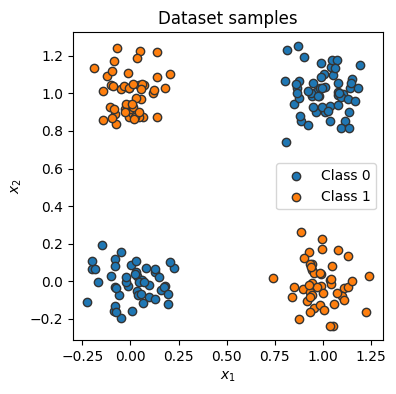

In [5]:
def visualize_binary_samples(dataset):
    """visualize a data set with binary labels.

    Args:
        data: the data set as, e.g., generated by XORDataset
    """
    (data,label) = dataset.toNumpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
visualize_binary_samples(dataset)
plt.show()

In [12]:
class SimpleClassifier(nn.Module):
    def __init__(self, src, tg, depth, width, device=device):
        """Make a convolutional neural network. Last layer uses the identity transfer function, the rest use the tanh.

        Args:
            src: The number of input nodes
            tg: The number of output nodes
            depth: The number of hidden layers
            width: The width of the hidden layers
        """
        super().__init__()
        self.enc_sizes = [src, tg, depth, width]


        ###############################################################################################
        # Assignment: replace self.model with your code for a network src-width-width-...-tg network
        ###############################################################################################
        functionLst = [nn.Linear(src, width, bias=True), nn.Tanh()]
        for i in range(depth):
            functionLst.append(nn.Linear(width, width, bias=True))
            functionLst.append(nn.Tanh())
        
        functionLst.append(nn.Linear(width, tg, bias=True))
        functionLst.append(nn.Identity())
        
        self.model = nn.Sequential(*functionLst) #unpacking with the '*' operator

        # Move data to GPU if relevant
        self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(dim=1) # flat

        return x

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    """Train a model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        data_loader: The function to load the data
        loss_module: The function to evaluate the loss function
        num_epochs: The number of epochs to train
    """
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Step 1: Run the model on the input data
            preds = model(data_inputs)
            #preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 2: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 4: Update the parameters
            optimizer.step()

def eval_model(model, data_loader):
    """Evaluate a model.

    Args:
        model: A (trained) model
        data_loader: The function to load the data
    """
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    return acc

In [13]:
###############################################################################################
# Assignment: replace the following with code that trains your networks repeatedly on the same
# XORDataset for a range of depths and widths, e.g., depths and widths in the range range(4)
# and each repeated 3 times.
###############################################################################################

loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

for width in range(1, 4):
    for depth in range(4):
        # Setup a feed-forward network with variable width
        model = SimpleClassifier(src=2, tg=1, depth=depth, width=width)
        #print(model)

        # Train
        accuracies = []
        for i in range(3):
            
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            train_model(model, optimizer, train_data_loader, loss_module, num_epochs=200)

            # Evaluate
            accuracies.append(eval_model(model, test_data_loader))
            
        n_params = 0
        
        for param in model.parameters():
            #count params
            n_params += param.numel()
        
        print(f"Number of parameters: {n_params}")
    
        accuracies = np.array(accuracies)
        print(f"Mean and std of accuracy with width: {width} and depth {depth}: {accuracies.mean()}, {accuracies.std()}")
        print("\n")


Number of parameters: 5
Mean and std of accuracy with width: 1 and depth 0: 0.7639999985694885, 0.0


Number of parameters: 7
Mean and std of accuracy with width: 1 and depth 1: 0.6793333888053894, 0.14519259333610535


Number of parameters: 9
Mean and std of accuracy with width: 1 and depth 2: 0.7099999785423279, 0.0


Number of parameters: 11
Mean and std of accuracy with width: 1 and depth 3: 0.5633333325386047, 0.12633639574050903


Number of parameters: 9
Mean and std of accuracy with width: 2 and depth 0: 0.625333309173584, 0.08198104053735733


Number of parameters: 15
Mean and std of accuracy with width: 2 and depth 1: 1.0, 0.0


Number of parameters: 21
Mean and std of accuracy with width: 2 and depth 2: 0.543999969959259, 0.09899495542049408


Number of parameters: 27
Mean and std of accuracy with width: 2 and depth 3: 0.9273333549499512, 0.10276618599891663


Number of parameters: 13
Mean and std of accuracy with width: 3 and depth 0: 0.9979999661445618, 5.960464477539063e-0